In [25]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================
# ตาม config ของระบบจริง
# ==============================
TICKERS = ["AEP", "DUK", "SO", "ED", "EXC"]
EXOG_TICKERS = {"Oil": "CL=F", "Gas": "NG=F", "XLU": "XLU"}
PERIOD = "5y"


In [26]:
def ensure_datetime_freq(series: pd.Series | pd.DataFrame, use_bdays=True):
    """คัดลอก logic จาก forecast.py เพื่อ align วันที่เป็นวันทำการ (BusinessDays)"""
    s = series.copy()
    if not isinstance(s.index, pd.DatetimeIndex):
        s.index = pd.to_datetime(s.index, errors="coerce")
    s = s[~s.index.isna()].sort_index()
    if len(s) == 0:
        return s
    inferred = pd.infer_freq(s.index)
    if inferred is None:
        full_idx = pd.bdate_range(s.index.min(), s.index.max()) if use_bdays else pd.date_range(s.index.min(), s.index.max())
        s = s.reindex(full_idx).ffill()
    return s


In [27]:
# ✅ ดึงราคาปิด
data = pd.DataFrame()

# หุ้นหลัก
for t in TICKERS:
    df = yf.download(t, period=PERIOD, progress=False, auto_adjust=True)
    s = df["Close"].dropna()
    s = ensure_datetime_freq(s)
    data[t] = s

# ตัวแปรภายนอก (exog)
for name, symbol in EXOG_TICKERS.items():
    df = yf.download(symbol, period=PERIOD, progress=False, auto_adjust=True)
    s = df["Close"].dropna()
    s = ensure_datetime_freq(s)
    data[name] = s

# align index ทั้งหมด
data = data.reindex(pd.bdate_range(data.index.min(), data.index.max())).ffill()
data.tail()


,AEP,DUK,SO,ED,EXC,Oil,Gas,XLU
2025-10-07,118.160004,125.559998,96.419998,100.040001,46.790001,61.730000,3.498,90.180000
2025-10-08,118.190002,125.230003,96.180000,100.830002,46.619999,62.549999,3.333,90.800003
2025-10-09,116.910004,124.709999,96.129997,100.800003,46.660000,61.509998,3.269,90.570000
2025-10-10,117.040001,127.019997,98.290001,102.389999,47.070000,58.900002,3.106,90.199997
2025-10-13,117.334999,126.754997,98.129997,101.029999,46.930000,59.759998,3.116,91.099998


In [28]:
returns = data.pct_change().dropna()
corr = returns.corr()
corr


,AEP,DUK,SO,ED,EXC,Oil,Gas,XLU
AEP,1.000000,0.808136,0.791330,0.771376,0.732154,0.011512,0.063872,0.825536
DUK,0.808136,1.000000,0.820347,0.829220,0.728343,-0.008747,0.048054,0.834279
SO,0.791330,0.820347,1.000000,0.791542,0.722550,0.015260,0.039412,0.828986
ED,0.771376,0.829220,0.791542,1.000000,0.704924,-0.024707,0.036388,0.786217
EXC,0.732154,0.728343,0.722550,0.704924,1.000000,0.036026,0.048699,0.779351
Oil,0.011512,-0.008747,0.015260,-0.024707,0.036026,1.000000,0.073303,0.061708
Gas,0.063872,0.048054,0.039412,0.036388,0.048699,0.073303,1.000000,0.078027
XLU,0.825536,0.834279,0.828986,0.786217,0.779351,0.061708,0.078027,1.000000


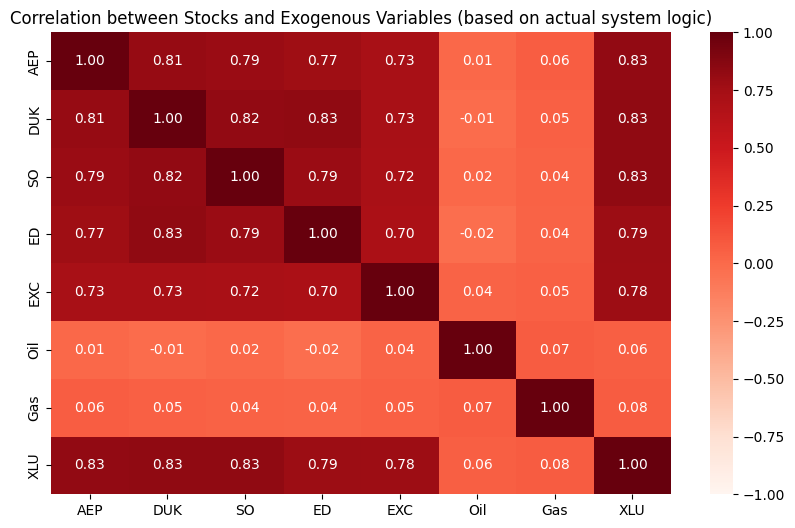

In [29]:
plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, cmap="Reds", fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation between Stocks and Exogenous Variables (based on actual system logic)")
plt.show()


In [30]:
corr_subset = corr.loc[TICKERS, EXOG_TICKERS.keys()]
corr_subset.style.background_gradient(cmap="coolwarm", axis=None)


,Oil,Gas,XLU
AEP,0.011512,0.063872,0.825536
DUK,-0.008747,0.048054,0.834279
SO,0.015260,0.039412,0.828986
ED,-0.024707,0.036388,0.786217
EXC,0.036026,0.048699,0.779351


In [31]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ===========================
# Config เหมือนระบบจริง
# ===========================
TICKERS = ["AEP", "DUK", "SO", "ED", "EXC"]
EXOG_TICKERS = {"Oil": "CL=F", "Gas": "NG=F", "XLU": "XLU"}
PERIOD = "5y"

def ensure_datetime_freq(series: pd.Series | pd.DataFrame, use_bdays=True):
    s = series.copy()
    if not isinstance(s.index, pd.DatetimeIndex):
        s.index = pd.to_datetime(s.index, errors="coerce")
    s = s[~s.index.isna()].sort_index()
    if len(s) == 0:
        return s
    inferred = pd.infer_freq(s.index)
    if inferred is None:
        full_idx = pd.bdate_range(s.index.min(), s.index.max()) if use_bdays else pd.date_range(s.index.min(), s.index.max())
        s = s.reindex(full_idx).ffill()
    return s


In [32]:
data = pd.DataFrame()

# หุ้น Utilities
for t in TICKERS:
    df = yf.download(t, period=PERIOD, progress=False, auto_adjust=True)
    s = df["Close"].dropna()
    s = ensure_datetime_freq(s)
    data[t] = s

# ตัวแปรภายนอก (Oil, Gas, XLU)
for name, sym in EXOG_TICKERS.items():
    df = yf.download(sym, period=PERIOD, progress=False, auto_adjust=True)
    s = df["Close"].dropna()
    s = ensure_datetime_freq(s)
    data[name] = s

data = data.reindex(pd.bdate_range(data.index.min(), data.index.max())).ffill()
data.tail()


,AEP,DUK,SO,ED,EXC,Oil,Gas,XLU
2025-10-07,118.160004,125.559998,96.419998,100.040001,46.790001,61.730000,3.498,90.180000
2025-10-08,118.190002,125.230003,96.180000,100.830002,46.619999,62.549999,3.333,90.800003
2025-10-09,116.910004,124.709999,96.129997,100.800003,46.660000,61.509998,3.269,90.570000
2025-10-10,117.040001,127.019997,98.290001,102.389999,47.070000,58.900002,3.106,90.199997
2025-10-13,117.334999,126.754997,98.129997,101.029999,46.930000,59.759998,3.113,91.099998


In [33]:
# สร้างสำเนา exog smoothing
data_smooth = data.copy()

# 🔹 ทำ rolling 5 วัน + normalize เฉพาะ Oil, Gas
for col in ["Oil", "Gas"]:
    s = data_smooth[col]
    s = (s - s.mean()) / (s.std() + 1e-6)
    s = s.rolling(window=5).mean().bfill()
    data_smooth[col] = s

# 🔹 XLU ใช้ตรง ๆ (ไม่แตะ)


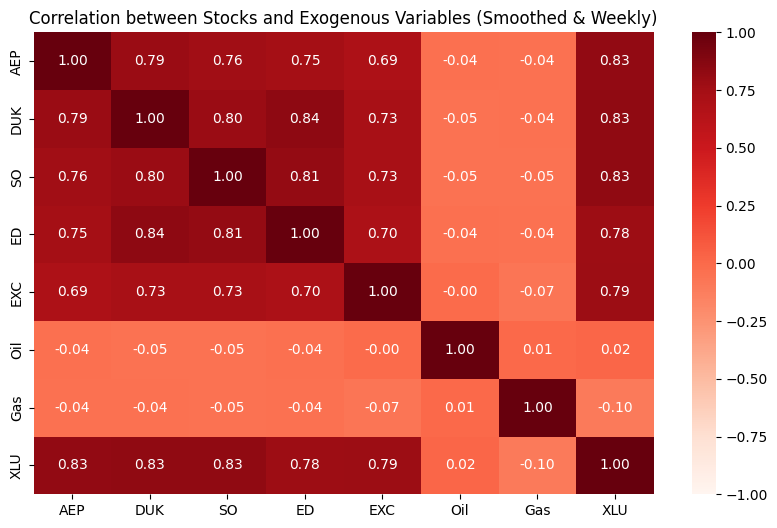

In [34]:
weekly = data_smooth.resample("W").last().pct_change().dropna()
corr = weekly.corr()

plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, cmap="Reds", fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation between Stocks and Exogenous Variables (Smoothed & Weekly)")
plt.show()


In [35]:
corr_subset = corr.loc[TICKERS, EXOG_TICKERS.keys()]
corr_subset.style.background_gradient(cmap="coolwarm", axis=None)


,Oil,Gas,XLU
AEP,-0.036854,-0.043100,0.826404
DUK,-0.053984,-0.043801,0.833419
SO,-0.050294,-0.048093,0.834004
ED,-0.037112,-0.044097,0.779116
EXC,-0.000290,-0.065203,0.786920


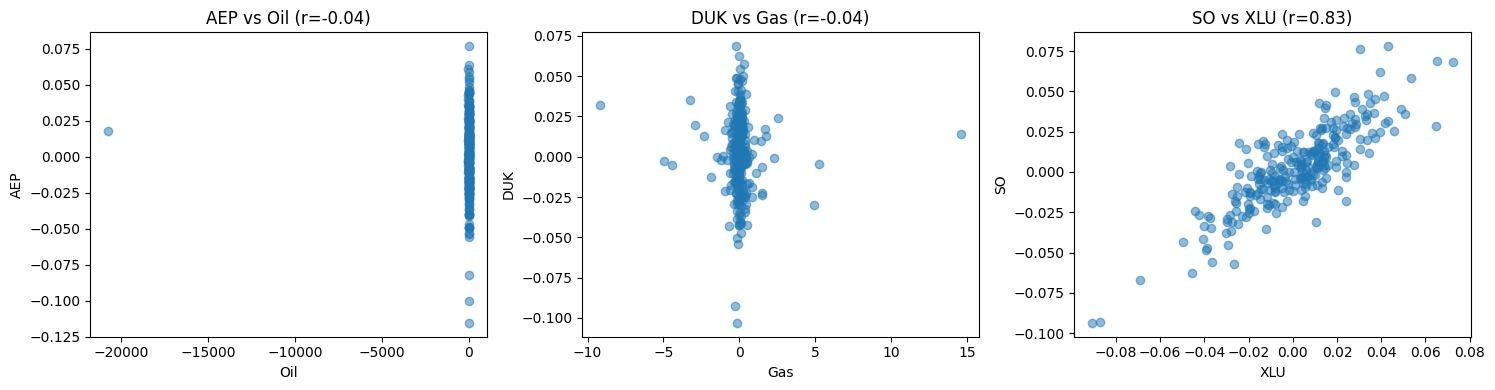

In [36]:
pairs = [("AEP", "Oil"), ("DUK", "Gas"), ("SO", "XLU")]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for i, (stk, exog) in enumerate(pairs):
    axes[i].scatter(weekly[exog], weekly[stk], alpha=0.5)
    axes[i].set_title(f"{stk} vs {exog} (r={corr.loc[stk, exog]:.2f})")
    axes[i].set_xlabel(exog)
    axes[i].set_ylabel(stk)
plt.tight_layout()
plt.show()


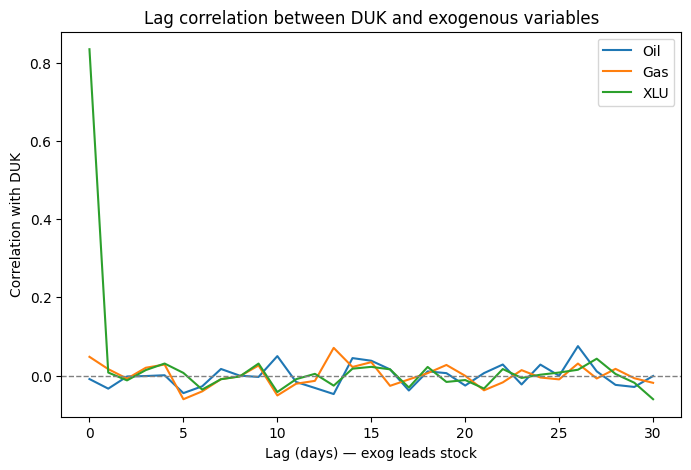

In [37]:
target = "DUK"   # หรือเปลี่ยนเป็น AEP, SO, ED, EXC ได้
max_lag = 30     # ดูย้อนหลังได้ถึง 30 วัน

corrs = {"Oil": [], "Gas": [], "XLU": []}
lags = range(0, max_lag + 1)

returns = data.pct_change().dropna()

for exog in corrs.keys():
    for lag in lags:
        shifted = returns[exog].shift(lag)
        c = returns[target].corr(shifted)
        corrs[exog].append(c)

plt.figure(figsize=(8,5))
for exog, vals in corrs.items():
    plt.plot(lags, vals, label=exog)
plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.xlabel("Lag (days) — exog leads stock")
plt.ylabel(f"Correlation with {target}")
plt.title(f"Lag correlation between {target} and exogenous variables")
plt.legend()
plt.show()


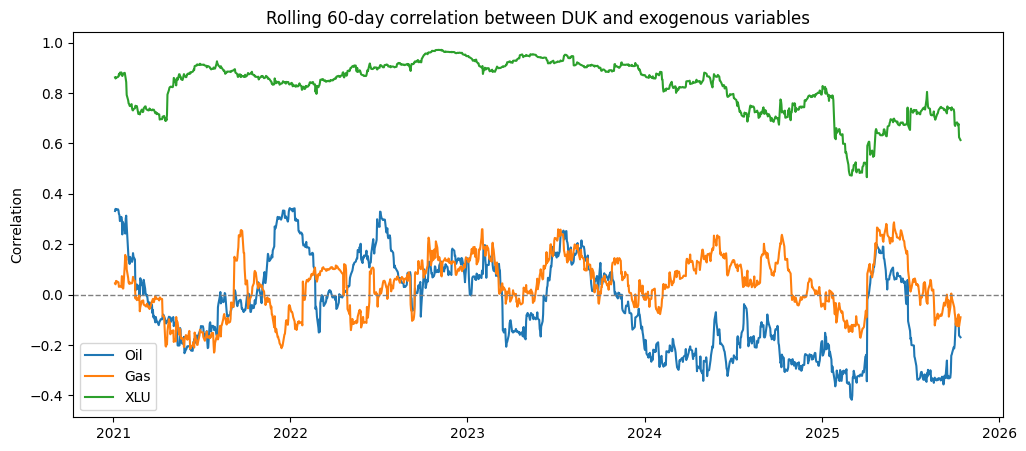

In [38]:
import seaborn as sns

target = "DUK"
window = 60  # 60 วัน

roll_corr = pd.DataFrame({
    exog: data[target].pct_change().rolling(window).corr(data[exog].pct_change())
    for exog in ["Oil", "Gas", "XLU"]
}).dropna()

plt.figure(figsize=(12,5))
for exog in roll_corr.columns:
    plt.plot(roll_corr.index, roll_corr[exog], label=exog)
plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.legend()
plt.title(f"Rolling 60-day correlation between {target} and exogenous variables")
plt.ylabel("Correlation")
plt.show()


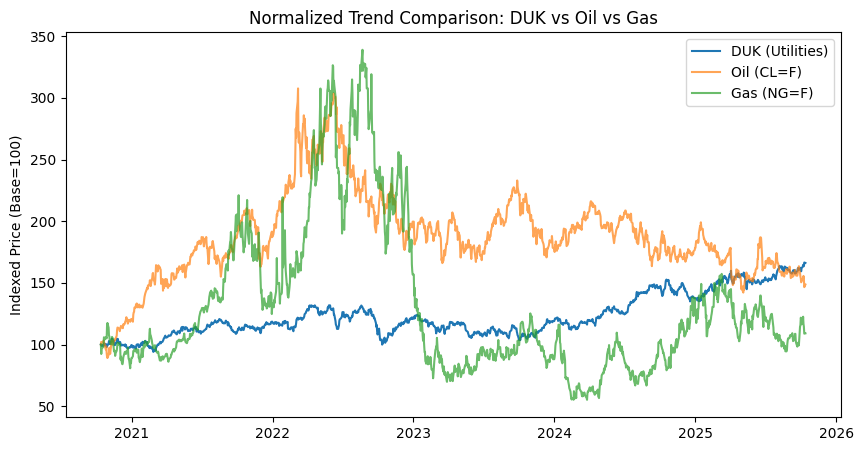

In [39]:
plt.figure(figsize=(10,5))
plt.plot(data["DUK"]/data["DUK"].iloc[0]*100, label="DUK (Utilities)")
plt.plot(data["Oil"]/data["Oil"].iloc[0]*100, label="Oil (CL=F)", alpha=0.7)
plt.plot(data["Gas"]/data["Gas"].iloc[0]*100, label="Gas (NG=F)", alpha=0.7)
plt.title("Normalized Trend Comparison: DUK vs Oil vs Gas")
plt.ylabel("Indexed Price (Base=100)")
plt.legend()
plt.show()


In [40]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

TICKERS = ["AEP", "DUK", "SO", "ED", "EXC"]
EXOG_TICKERS = {"Oil": "CL=F", "Gas": "NG=F", "XLU": "XLU"}

PERIOD = "5y"

def ensure_datetime_freq(series: pd.Series | pd.DataFrame, use_bdays=True):
    s = series.copy()
    if not isinstance(s.index, pd.DatetimeIndex):
        s.index = pd.to_datetime(s.index, errors="coerce")
    s = s[~s.index.isna()].sort_index()
    if len(s) == 0:
        return s
    inferred = pd.infer_freq(s.index)
    if inferred is None:
        full_idx = pd.bdate_range(s.index.min(), s.index.max()) if use_bdays else pd.date_range(s.index.min(), s.index.max())
        s = s.reindex(full_idx).ffill()
    return s

data = pd.DataFrame()

for t in TICKERS:
    df = yf.download(t, period=PERIOD, progress=False, auto_adjust=True)
    s = df["Close"].dropna()
    s = ensure_datetime_freq(s)
    data[t] = s

for name, sym in EXOG_TICKERS.items():
    df = yf.download(sym, period=PERIOD, progress=False, auto_adjust=True)
    s = df["Close"].dropna()
    s = ensure_datetime_freq(s)
    data[name] = s

data = data.reindex(pd.bdate_range(data.index.min(), data.index.max())).ffill()
returns = data.pct_change().dropna()


In [41]:
max_lag = 30
corr_matrix = pd.DataFrame(index=TICKERS, columns=EXOG_TICKERS.keys())

for stock in TICKERS:
    for exog in EXOG_TICKERS.keys():
        best_corr = -999
        best_lag = 0
        for lag in range(0, max_lag + 1):
            shifted = returns[exog].shift(lag)
            c = returns[stock].corr(shifted)
            if abs(c) > abs(best_corr):
                best_corr, best_lag = c, lag
        corr_matrix.loc[stock, exog] = best_corr

corr_matrix = corr_matrix.astype(float)
corr_matrix


,Oil,Gas,XLU
AEP,-999.0,-999.0,-999.0
DUK,-999.0,-999.0,-999.0
SO,-999.0,-999.0,-999.0
ED,-999.0,-999.0,-999.0
EXC,-999.0,-999.0,-999.0


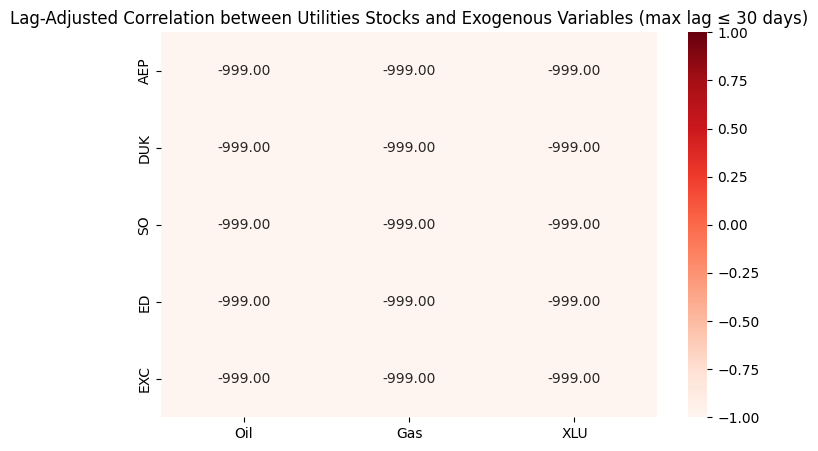

In [42]:
plt.figure(figsize=(8,5))
sns.heatmap(corr_matrix, annot=True, cmap="Reds", vmin=-1, vmax=1, fmt=".2f")
plt.title("Lag-Adjusted Correlation between Utilities Stocks and Exogenous Variables (max lag ≤ 30 days)")
plt.show()
